In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import gridspec

In [2]:
def read_data(only_BP=True):
    limb_behst = pd.read_csv('./data/term_heatmap/limb_behst_go_terms_sig.txt', sep='\t')
    limb_behst = limb_behst[limb_behst['p_value'] <= 0.05]
    
    limb_great = pd.read_csv('./data/term_heatmap/limb_great_go_terms_sig.txt', sep='\t')
    
    limb_chip = pd.read_csv('./data/term_heatmap/limb_chip_go_terms_sig.txt', sep='\t')
    
    limb_ref = pd.read_csv('./data/term_heatmap/limb_ref_go_terms.txt', sep='\t')
    limb_ref = limb_ref[limb_ref['p_value'] <= 0.05]

    if only_BP:
        limb_behst = limb_behst[limb_behst['source'] == 'GO:BP'].reset_index(drop=True)
        limb_great = limb_great[limb_great['source'] == 'GO:BP'].reset_index(drop=True)
        limb_chip = limb_chip[limb_chip['source'] == 'GO:BP'].reset_index(drop=True)
        limb_ref = limb_ref[limb_ref['source'] == 'GO:BP'].reset_index(drop=True)
    else: # GO:BP and GO:MF
        limb_behst = limb_behst[limb_behst['source'] != 'GO:CC'].reset_index(drop=True)
        limb_great = limb_great[limb_great['source'] != 'GO:CC'].reset_index(drop=True)
        limb_chip = limb_chip[limb_chip['source'] != 'GO:CC'].reset_index(drop=True)
        limb_ref = limb_ref[limb_ref['source'] != 'GO:CC'].reset_index(drop=True)
        
    return limb_behst, limb_great, limb_chip, limb_ref

In [3]:
def calc_quantile(df):
    """
    Calculate the quantile of a term
    """
    df = df.reset_index()
    df['quantile'] = df['index'] / len(df)
    df = df.drop(columns=['index'])
    
    return df

In [4]:
limb_behst, limb_great, limb_chip, limb_ref = read_data(only_BP=True)

In [5]:
limb_behst = calc_quantile(limb_behst)
limb_great = calc_quantile(limb_great)
limb_chip = calc_quantile(limb_chip)

In [6]:
def merge_data(limb_behst, limb_great, limb_chip):
    # merge first two datasets
    limb_behst_great = pd.merge(limb_behst, limb_great, on=['term_id','source'], how='outer', indicator=True)
    # keep one column of term name
    limb_behst_great['term_name'] = np.where(limb_behst_great['term_name_x'].notna(), limb_behst_great['term_name_x'],
                                         limb_behst_great['term_name_y'])
    limb_behst_great = limb_behst_great.drop(columns=['term_name_x','term_name_y'])
    
    limb_behst_great[['quantile_x', 'quantile_y']] = limb_behst_great[['quantile_x', 'quantile_y']].fillna(1)
    limb_behst_great = limb_behst_great.rename(columns={'p_value_x':'p_value_behst',
                                                   'p_value_y':'p_value_great',
                                                   'quantile_x':'quantile_behst',
                                                   'quantile_y':'quantile_great'})
    # drop merge status
    limb_behst_great = limb_behst_great.drop(columns=['_merge'])
    
    # merge the 3rd dataset together
    limb_all = pd.merge(limb_behst_great, limb_chip, on=['term_id','source'], how='outer', indicator=True)
    limb_all['term_name'] = np.where(limb_all['term_name_x'].notna(), limb_all['term_name_x'],
                                         limb_all['term_name_y'])
    limb_all = limb_all.drop(columns=['term_name_x','term_name_y'])
    
    limb_all = limb_all.rename(columns={'quantile':'quantile_chip'})
    limb_all[['quantile_behst', 'quantile_great', 'quantile_chip']] = limb_all[['quantile_behst', 'quantile_great', 
                                                                                'quantile_chip']].fillna(1)
    limb_all['quantile_sum'] = limb_all['quantile_behst'] + limb_all['quantile_great'] + limb_all['quantile_chip']
    limb_all = limb_all.sort_values('quantile_sum')
    limb_all = limb_all.drop(columns=['_merge'])
    
    # merge with ground truth dataset
    limb_all = pd.merge(limb_all, limb_ref, on=['term_id','source'], how='left', indicator=True)
    limb_all['ground_truth'] = np.where(limb_all['_merge'] == 'both', 0, 1)
    limb_all['term_name'] = np.where(limb_all['term_name_x'].notna(), limb_all['term_name_x'],
                                         limb_all['term_name_y'])
    limb_all = limb_all.drop(columns=['term_name_x','term_name_y'])
    
    return limb_all

In [7]:
def create_color_scale():
    heatmap_colors = ["navy", "royalblue", "cornflowerblue", "lightsteelblue",
                      "gainsboro"]
    cmap = LinearSegmentedColormap.from_list("mycmap", heatmap_colors)

    viridis = cm.get_cmap(cmap, 256)
    newcolors = viridis(np.linspace(0, 1, 100000))
    white = np.array([255 / 256, 255 / 256, 255 / 256, 1])
    newcolors[99999:, :] = white
    newcmp = ListedColormap(newcolors)

    return newcmp

In [8]:
def plot_term_heatmap(terms, ground_truth, cmap, title):
    fig = plt.figure(figsize=(12, 10), dpi=300)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    ax0 = sns.heatmap(terms, cmap=cmap, cbar=False)
    ax1 = plt.subplot(gs[1])
    ax1 = sns.heatmap(ground_truth, cmap=cmap, yticklabels=False,
                      cbar_kws={'shrink': 2.0, 'label': 'Quantile of term'})
    ax1.set_ylabel('')

    fig.tight_layout(pad=1.2)
    plt.savefig(title)
    # plt.show()

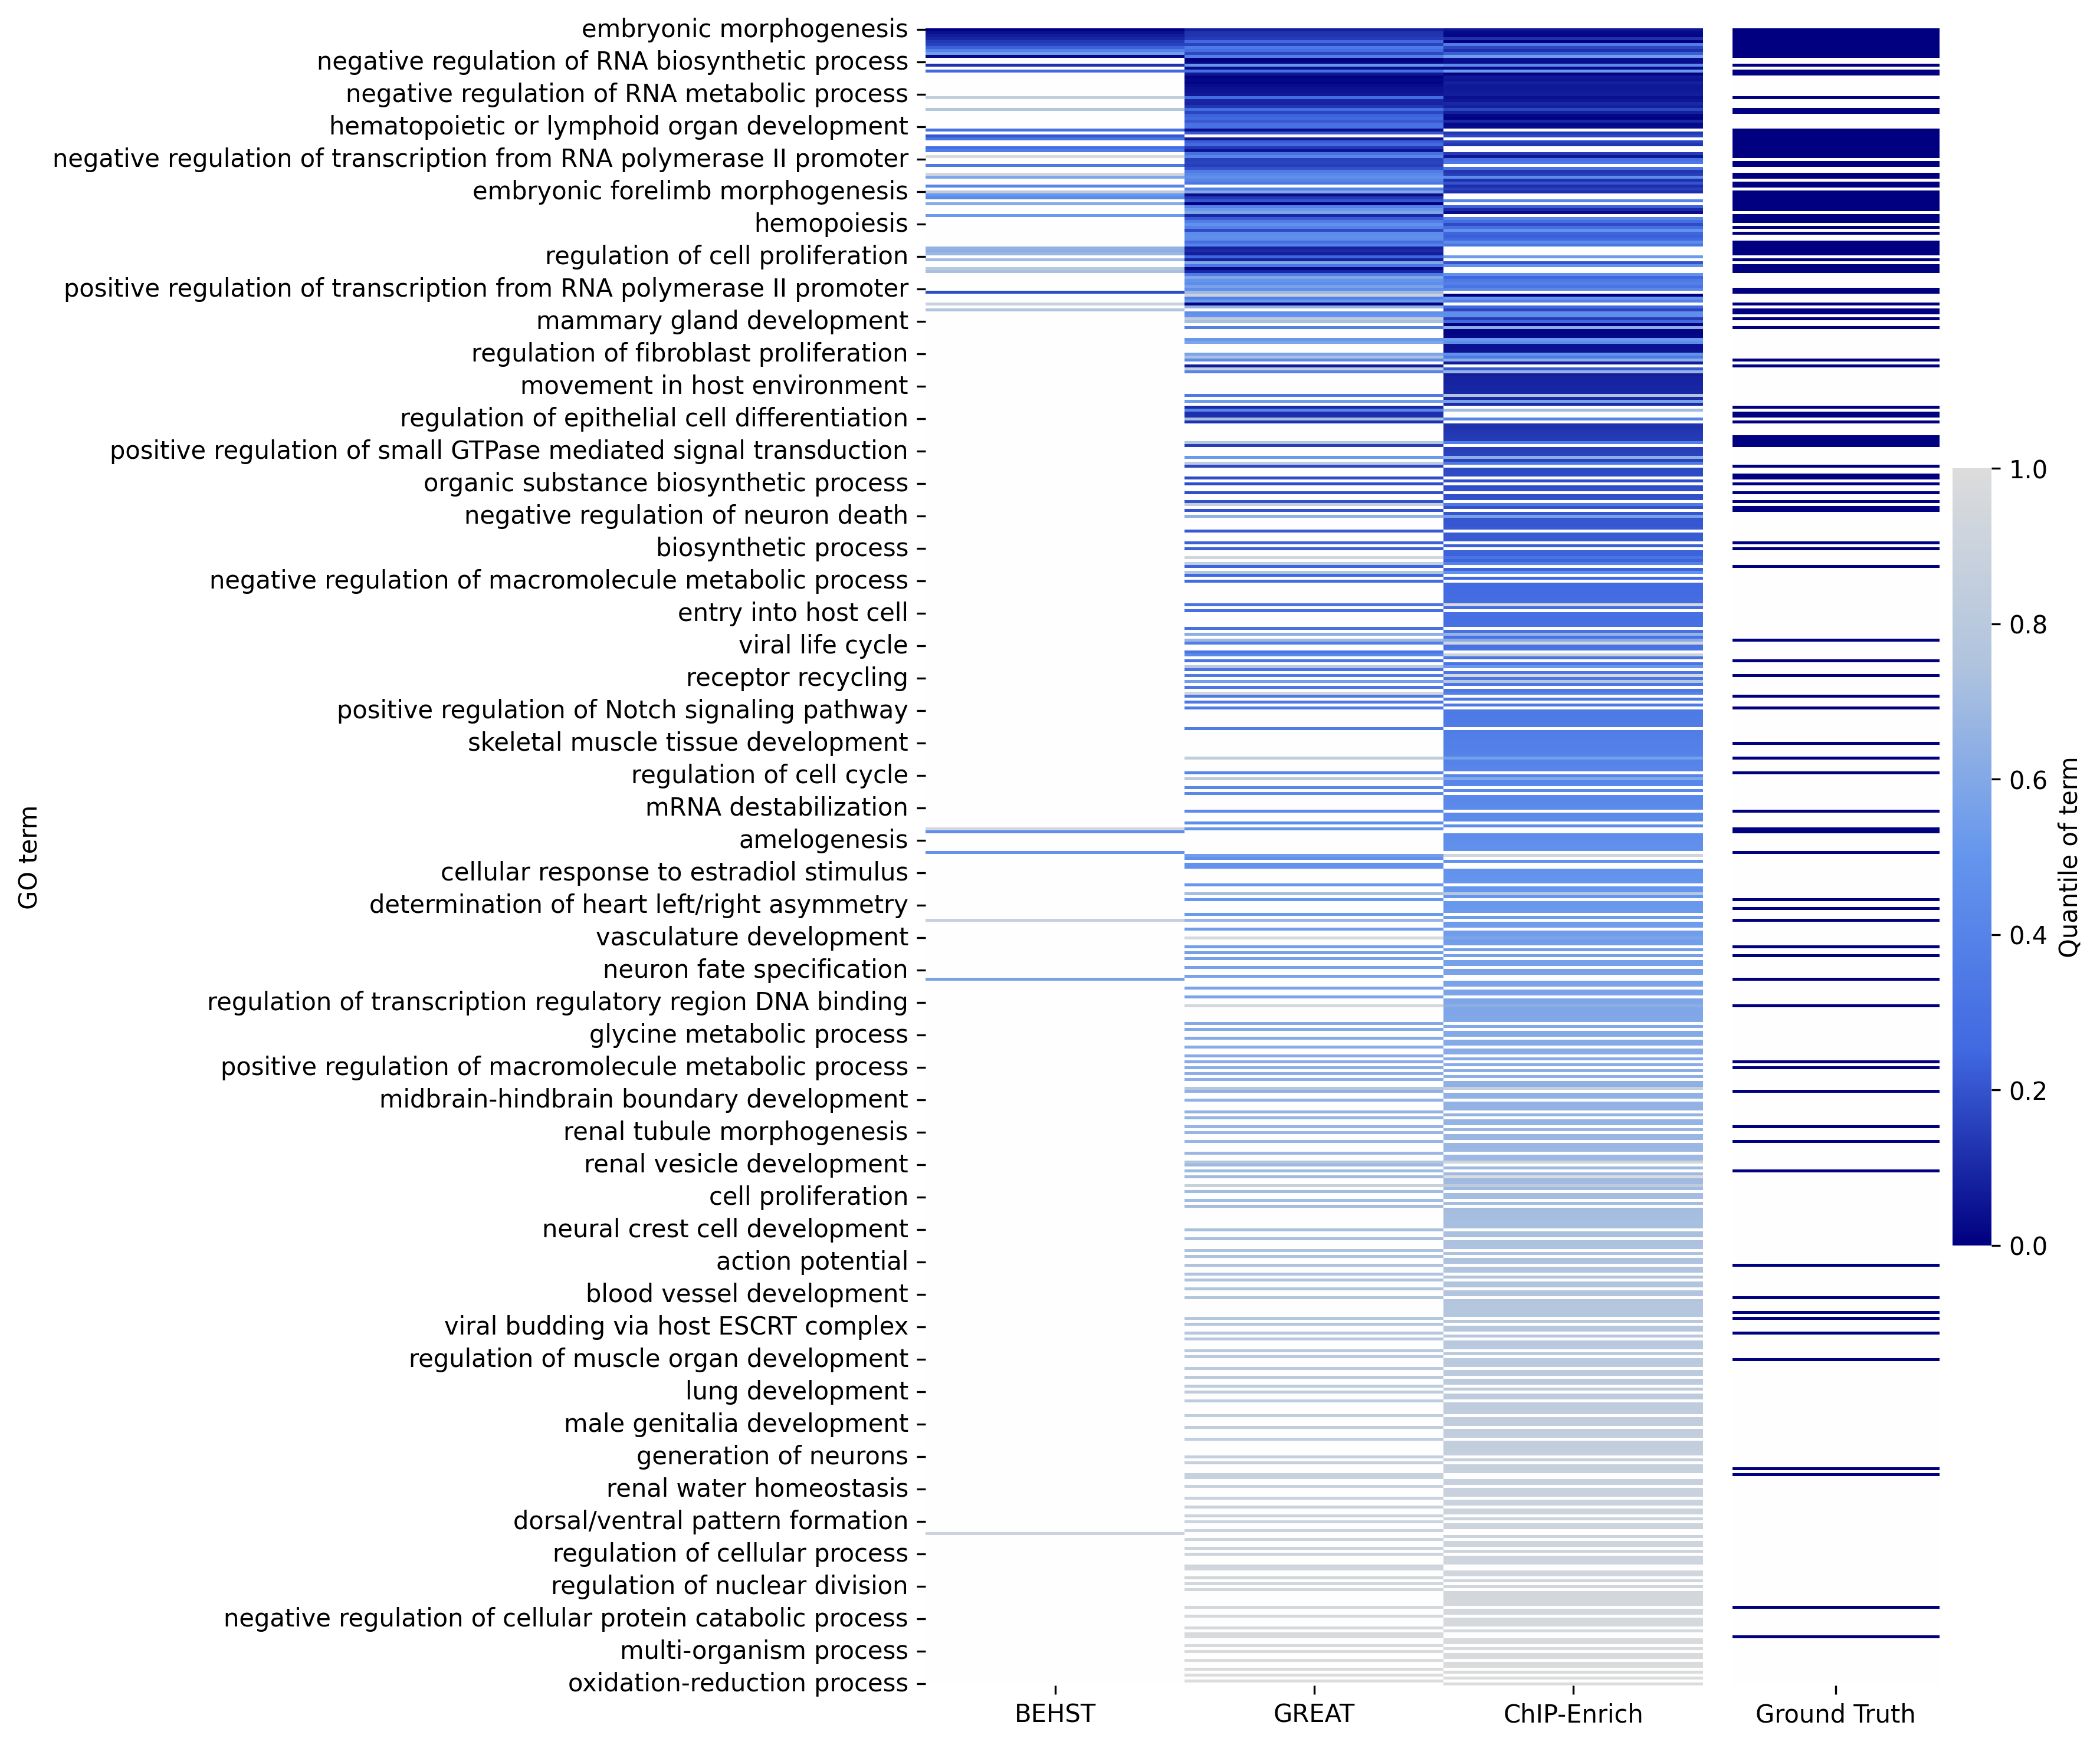

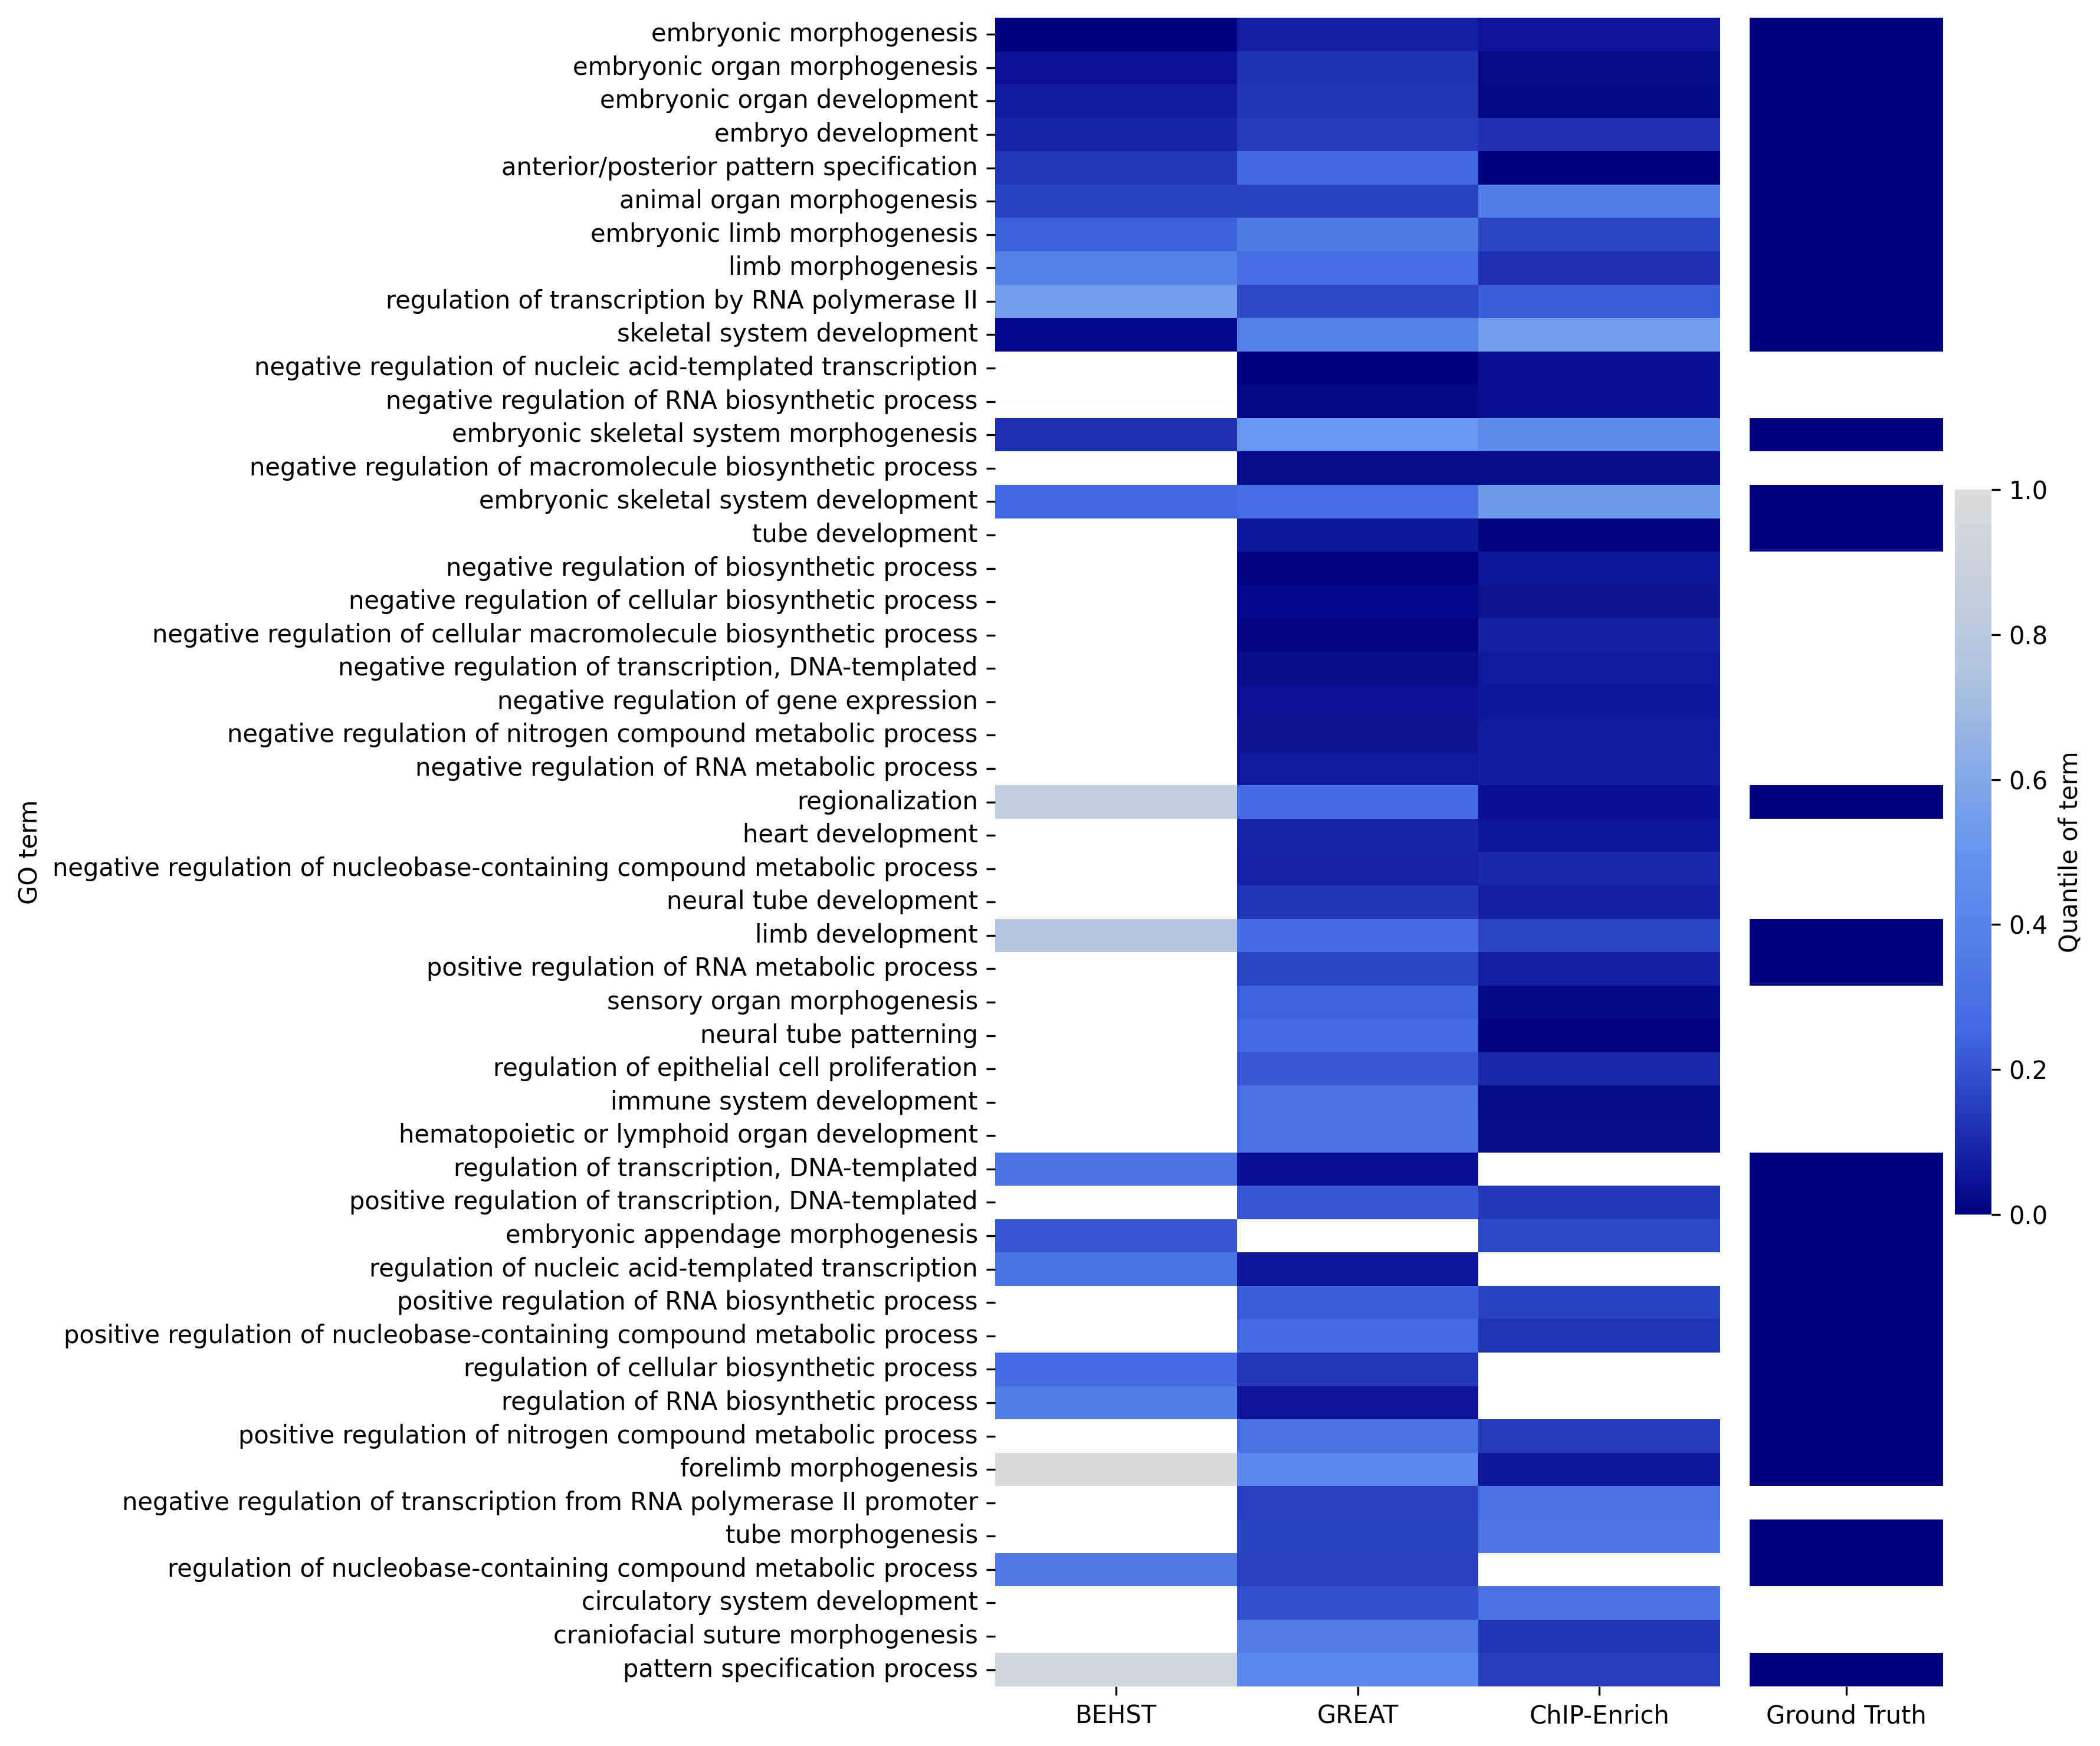

In [9]:
# select useful columns and create df for heatmap
limb_all = merge_data(limb_behst, limb_great, limb_chip)
limb_all_heatmap_df = limb_all[['term_name', 'quantile_behst', 'quantile_great', 'quantile_chip', 'ground_truth']]
limb_all_heatmap_df.columns = ['GO term', 'BEHST', 'GREAT', 'ChIP-Enrich', 'Ground Truth']
limb_all_heatmap_df = limb_all_heatmap_df.set_index('GO term')

limb_subplot_all = limb_all_heatmap_df[['BEHST', 'GREAT', 'ChIP-Enrich']]
limb_subplot_all_ref = limb_all_heatmap_df[['Ground Truth']]

# select top 50 terms
limb_subplot_top = limb_all_heatmap_df[['BEHST', 'GREAT', 'ChIP-Enrich']].head(50)
limb_subplot_top_ref = limb_all_heatmap_df[['Ground Truth']].head(50)

# create color scale
cmap = create_color_scale()

plot_term_heatmap(limb_subplot_all, limb_subplot_all_ref, cmap, "term_comparison_all.png")
plot_term_heatmap(limb_subplot_top, limb_subplot_top_ref, cmap, 'term_comparison_top_50.png')